# Does a cell state in the Ct represent Snow?

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Plot the snow 

In [4]:
print([v for v in static.data_vars if "snow" in v])
print([v for v in static.data_vars if "name" in v])

snowy_threshold = 0.05
gdf = gpd.GeoDataFrame(static["frac_snow"].to_dataframe().join(static["gauge_name"].to_dataframe()).join(points))

print(f"{(gdf.frac_snow > snowy_threshold).mean() * 100:.2f}% Catchments with snow percentage >{snowy_threshold}")
snowy_catchment_ids = gdf.loc[gdf.frac_snow > snowy_threshold]

['frac_snow']
['gauge_name']
5.37% Catchments with snow percentage >0.05


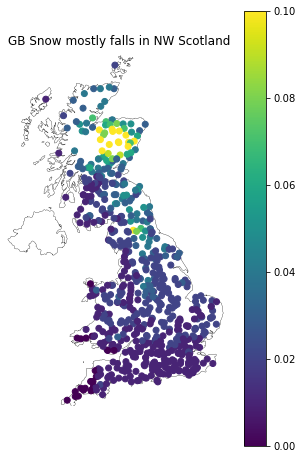

In [5]:
ax = initialise_gb_spatial_plot()
gdf.plot("frac_snow", ax=ax, legend=True, vmax=0.1)
ax.set_title("GB Snow mostly falls in NW Scotland");

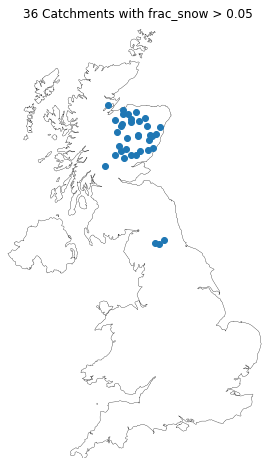

In [6]:
ax = initialise_gb_spatial_plot()
snowy_catchment_ids.plot(ax=ax)
N = len(snowy_catchment_ids)
ax.set_title(f"{N} Catchments with frac_snow > {snowy_threshold}");

# ERA5 Land Snow

In [7]:
era5filepath = (data_dir / "camels_basin_ERA5Land_sm.nc")
era5_sm = xr.open_dataset(era5filepath).drop("spatial_ref")


from scripts.cell_state.normalize import normalize_2d_dataset

if not isinstance(era5_sm, xr.Dataset):
    era5_sm = era5_sm.to_dataset()

for var in era5_sm.data_vars:
    era5_sm[var] = normalize_2d_dataset(era5_sm, variable_str=var, per_basin=True)

Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)
Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)
Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/t

In [8]:
# era5_sm.to_netcdf(data_dir / "SOIL_MOISTURE/FINAL/era5land_normalized.nc")

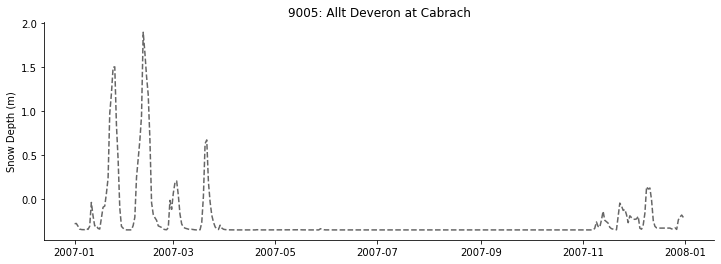

In [9]:
px = np.random.choice(snowy_catchment_ids.index)
data = era5_sm["sd"].sel(station_id=px, time="2007")
station = snowy_catchment_ids.loc[px]["gauge_name"]
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.time, data.values, ls="--", alpha=0.6, color="k")
ax.set_ylabel("Snow Depth (m)");
ax.set_title(f"{px}: {station}")
sns.despine()

# Cell State Data

In [10]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable


if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")

In [11]:
cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

# Train the linear probe!

In [12]:
from scripts.cell_state.analysis import calculate_raw_correlations
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

train_start_date = cs.time.min().values
train_end_date = pd.to_datetime("2006-09-30")
test_start_date = pd.to_datetime("2006-10-01")
test_end_date =  cs.time.max().values

input_variables = [v for v in cs.data_vars]
TARGET_VAR = "sd"
subset_pixels = True

subset_pixels = snowy_catchment_ids.index

In [13]:
if subset_pixels is not None:
    target_data = cs.sel(time=slice(train_start_date, train_end_date), station_id=subset_pixels)
    input_data = era5_sm.sel(time=slice(train_start_date, train_end_date), station_id=subset_pixels)
    
    test_target_data = cs.sel(time=slice(test_start_date, test_end_date), station_id=subset_pixels)
    test_input_data = era5_sm.sel(time=slice(test_start_date, test_end_date), station_id=subset_pixels)

else:
    target_data = cs.sel(time=slice(train_start_date, train_end_date))
    input_data = era5_sm.sel(time=slice(train_start_date, train_end_date))
    
    test_target_data = cs.sel(time=slice(test_start_date, test_end_date))
    test_input_data = era5_sm.sel(time=slice(test_start_date, test_end_date))


# create pytorch dataloaders 
train_dataset = TimeSeriesDataset(
    input_data=target_data,
    target_data=input_data,
    target_variable=TARGET_VAR,
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Train Samples",
)

test_dataset = TimeSeriesDataset(
    input_data=test_target_data,
    target_data=test_input_data,
    target_variable=TARGET_VAR,
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Test Samples",
)

Creating Test Samples: 100%|██████████| 36/36 [00:00<00:00, 137.00it/s]


## create data samples

In [14]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

X, y, times, station_ids = get_time_basin_aligned_samples(train_dataset)
X_test, y_test, times_test, station_ids_test = get_time_basin_aligned_samples(test_dataset)

Extracting Data:  13%|█▎        | 15/116 [00:00<00:00, 146.50it/s]

Merging and reshaping arrays


Extracting Data: 100%|██████████| 116/116 [00:00<00:00, 144.26it/s]

Merging and reshaping arrays


## fit and predict

In [15]:
from sklearn.linear_model import SGDRegressor
from scripts.read_nh_results import calculate_all_error_metrics

np.random.seed(seed=1)
model = SGDRegressor(
    loss="huber",
    penalty="elasticnet",
    alpha=0.01,
    l1_ratio=0.15,            # default
    fit_intercept=True, 
    n_iter_no_change=10,
    early_stopping=True
)

In [16]:
model.fit(X, y.ravel())

SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=10,
             penalty='elasticnet')

### Test predictions

In [17]:
## Hold out test predictions
y_hat = model.predict(X_test)
preds = pd.DataFrame({
    "station_id": station_ids_test.ravel(),
    "time": times_test.astype("datetime64[ns]").ravel(),
    "obs": y_test.ravel(),
    "sim": y_hat.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

errors = calculate_all_error_metrics(
    preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "RMSE", "MSE"],
)

Calculating Errors: 100%|██████████| 36/36 [00:00<00:00, 60.56it/s, 25012]


### train predictions

In [18]:
if True:
    y_hat_train = model.predict(X)
    print("Made Predictions")
    
    train_preds = pd.DataFrame({
        "station_id": station_ids.ravel(),
        "time": times.astype("datetime64[ns]").ravel(),
        "obs": y.ravel(),
        "sim": y_hat_train.ravel(),
    }).set_index(["station_id", "time"]).to_xarray()

    train_errors = calculate_all_error_metrics(
        train_preds,
        basin_coord="station_id",
        time_coord="time",
        obs_var="obs",
        sim_var="sim",
        metrics=["NSE", "RMSE", "MSE"],
    )

Calculating Errors:  19%|█▉        | 7/36 [00:00<00:00, 63.96it/s, 9004]

Made Predictions


Calculating Errors: 100%|██████████| 36/36 [00:00<00:00, 63.44it/s, 25012]


## Analysis dataset

In [19]:
from scripts.cell_state.timeseries_model import _round_time_to_hour

# create dataframes of X/y for model
_x_df = pd.DataFrame(
    {f"dim{i}": X[:, i] for i in range(X.shape[-1])}
)
_df = pd.DataFrame({
    "station_id": station_ids.ravel(), "time": times.astype("datetime64[ns]").ravel(), "y": y.ravel(), 
})
analysis_df = _df.join(_x_df).set_index(["time", "station_id"])
analysis_ds = analysis_df.to_xarray()
analysis_ds["time"] = _round_time_to_hour(analysis_ds["time"].values)

_x_df = pd.DataFrame(
    {f"dim{i}": X_test[:, i] for i in range(X_test.shape[-1])}
)
_df = pd.DataFrame({
    "station_id": station_ids_test.ravel(), "time": times_test.astype("datetime64[ns]").ravel(), "y": y_test.ravel(), 
})
test_analysis_df = _df.join(_x_df).set_index(["time", "station_id"])
test_analysis_ds = test_analysis_df.to_xarray()

### create the xarray object
analysis_ds = xr.concat([analysis_ds, test_analysis_ds], dim="time")

# Results

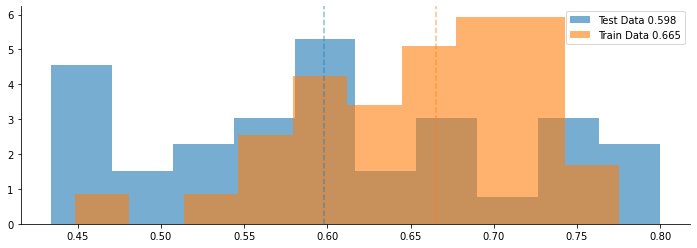

In [20]:
rmse = errors["RMSE"]
nse = errors["NSE"]
rmse_train = train_errors["RMSE"]
nse_train = train_errors["NSE"]


# nse.where(nse > -1, -1)
f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=10, density=True, label=f"Test Data {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

ax.hist(nse_train.where(nse > -1, -1), bins=10, density=True, label=f"Train Data {nse_train.median().values:.3f}", alpha=0.6);
ax.axvline(nse_train.median(), color="C1", ls="--", alpha=0.5)

ax.legend()
sns.despine()

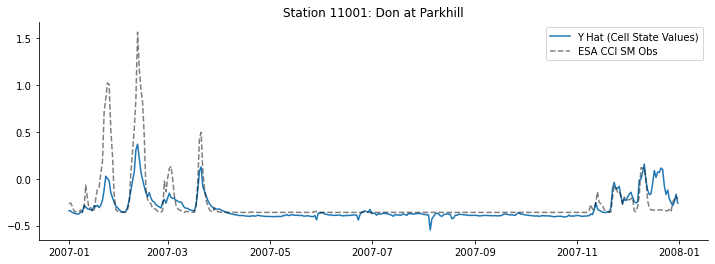

In [21]:
px = np.random.choice(snowy_catchment_ids.index)
time_str = "2007"

# select station id, time
data = preds.sel(station_id=px, time=time_str).to_dataframe()

f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.index, data["sim"], label="Y Hat (Cell State Values)")
ax.plot(data.index, data["obs"], alpha=0.5, color="k", ls="--", label="ESA CCI SM Obs")
ax.set_title(f"Station {px}: {snowy_catchment_ids.loc[px].gauge_name}")
ax.legend()
sns.despine()

# what about the weights?

<AxesSubplot:>

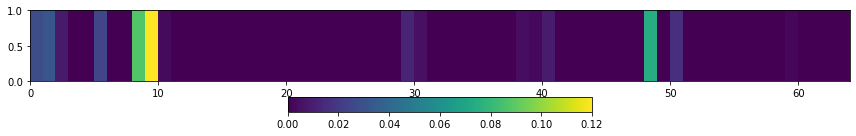

In [22]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

w, b = get_model_weights(model)
plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.12})

In [23]:
max_idx = np.argmax(np.abs(w))
n = 2
largest_n = np.abs(w).argsort()[-n:][::-1]
feature = f"dim{max_idx}"

features = [f"dim{idx}" for idx in largest_n]
assert feature in analysis_ds.data_vars

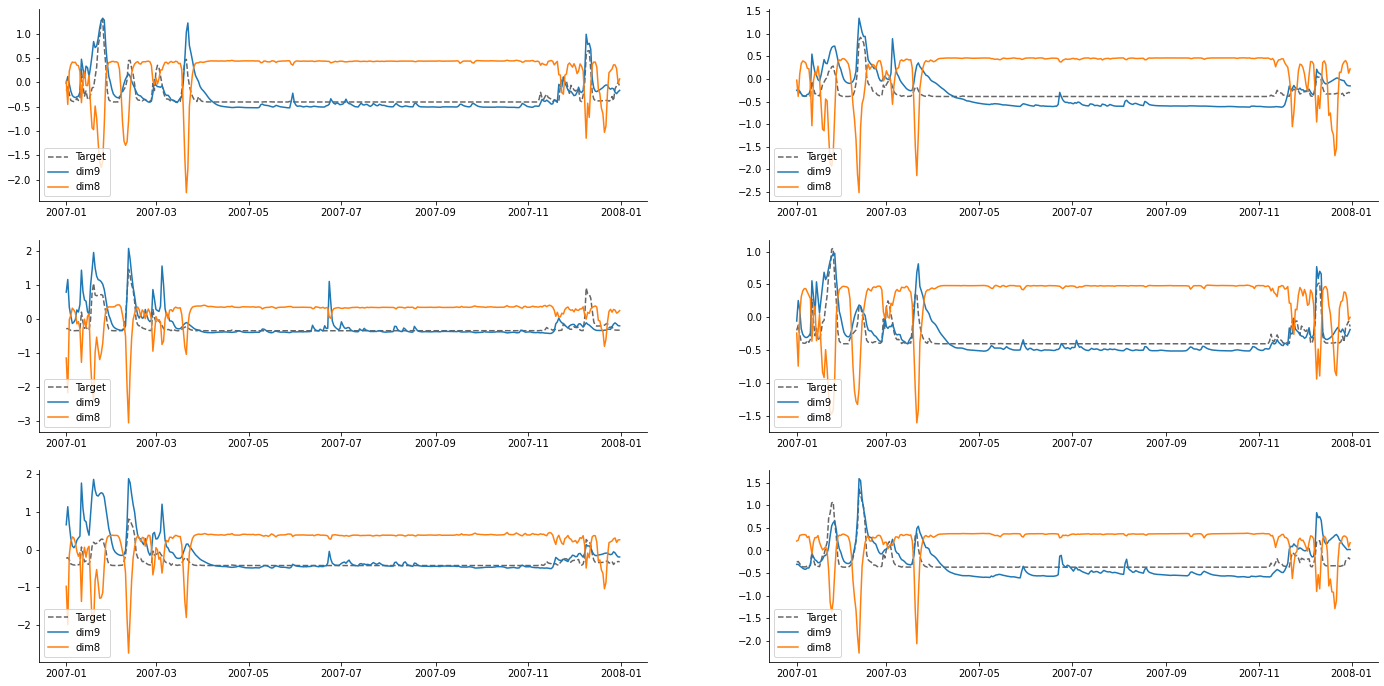

In [24]:
time = "2007"

pixels = np.random.choice(analysis_ds.station_id.values, 6)
f, axs = plt.subplots(3, 2, figsize=(12*2, 4*3))

for ix, px in enumerate(pixels):
    ax = axs[np.unravel_index(ix, (3, 2))]
    data = analysis_ds.sel(station_id=px, time=time).to_dataframe()
    ax.plot(data.index, data["y"], label="Target", color="k", ls="--", alpha=0.6)
    ax.legend(loc="upper right")

    # ax2 = ax.twinx()
    for ix, feature in enumerate(features):  # features  ["dim20"]
        ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
        ax.legend(loc="lower left")

    sns.despine()

# Raw correlation coefficnents?

In [25]:
from tqdm import tqdm

correlations = []
pbar = tqdm(range(X.shape[-1]), desc="Calculating correlations for each dimension")
for i in pbar:
    corr = np.corrcoef(X[:, i], y, rowvar=False)[0, 1]
    correlations.append(corr)
    
correlations = np.array(correlations)

Calculating correlations for each dimension: 100%|██████████| 64/64 [00:00<00:00, 607.96it/s]


<AxesSubplot:>

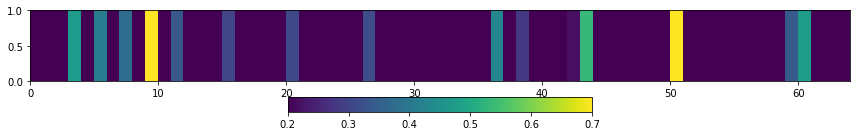

In [26]:
plot_weights(correlations.reshape(1, -1), kwargs={"vmin": 0.2, "vmax": 0.7})

# What about in non-snowy catchments?

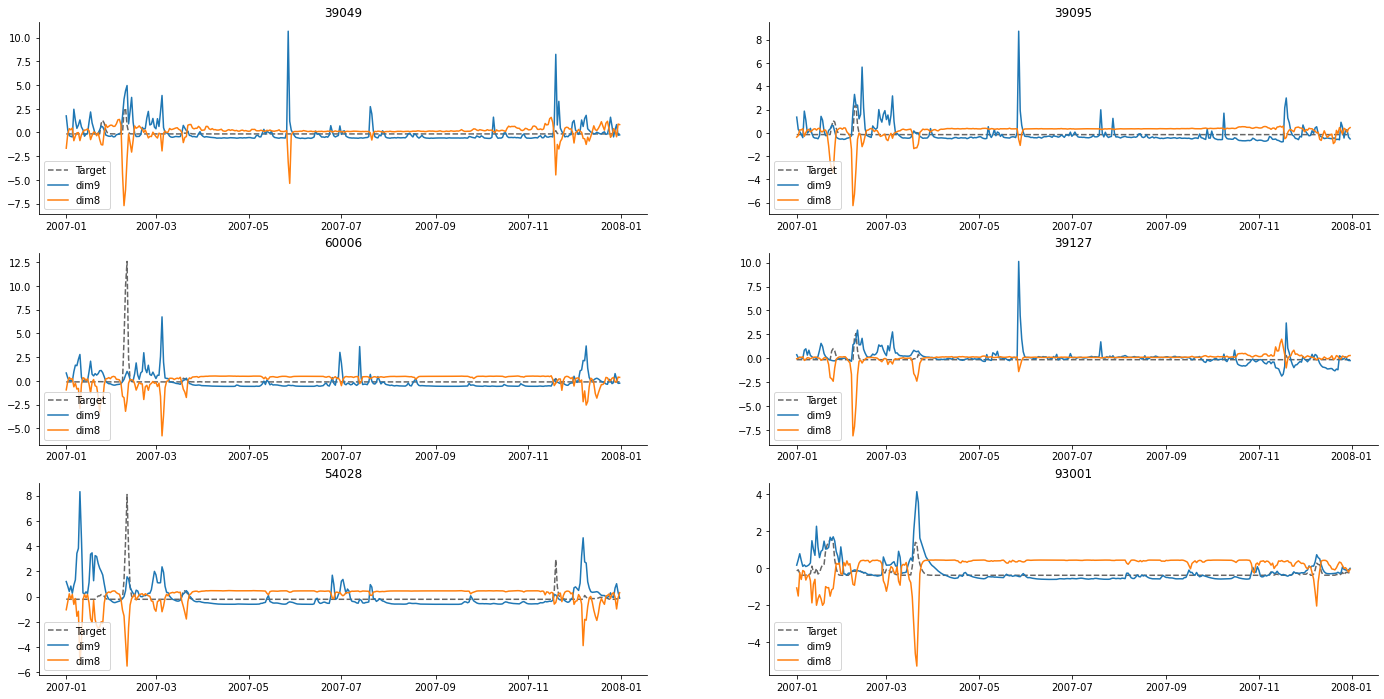

In [48]:
non_snow_sids = [f for f in static.station_id.values if f not in snowy_catchment_ids.index]
time = "2007"

pixels = np.random.choice(non_snow_sids, 6)
f, axs = plt.subplots(3, 2, figsize=(12*2, 4*3))

for ix, px in enumerate(pixels):
    ax = axs[np.unravel_index(ix, (3, 2))]
    snow_data = era5_sm.sel(station_id=px, time=time).to_dataframe()
    ax.plot(snow_data.index, snow_data["sd"], label="Target", color="k", ls="--", alpha=0.6)
    ax.legend(loc="upper right")

    # ax2 = ax.twinx()
    data = cs.sel(station_id=px, time=time).to_dataframe()
    for ix, feature in enumerate(features):  # features  ["dim20"]
        ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
        ax.legend(loc="lower left")
    
    ax.set_title(px)
    sns.despine()